In [ ]:
# default_exp rl.policies.bandit_policies

# Bandit Policies
> Implementation of bandit policies including UCB and TS.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
from abc import ABC, abstractmethod

In [ ]:
#export
class ABPolicy(ABC):
    def __init__(self, bandit, slate_size, scores_logging):
        self.name = None
        self.slate_size = slate_size
        self.history = pd.DataFrame(data=None, columns=['item_id', 'reward'])
        if scores_logging is True:
            self.scores_log = pd.DataFrame(data=None, columns=bandit.actions)
        else:
            self.scores_log = None

    @abstractmethod
    def get_recommendations(self):
        ...

    def update(self, rewards):
        # append new events to history
        self.history = self.history.append(rewards, ignore_index=True)
    
    def _sort_actions(self, scores):
        """ Sort actions by score and shuffle actions with same score
            Inputs:
                scores: pandas.Series with actions as index """
        sorted_actions = sorted(
            scores.sample(frac=1).index,
            key=lambda idx: scores.loc[idx],
            reverse=True)
        return sorted_actions

    def _update_scores_history(self, scores):
        if self.scores_log is not None:
            self.scores_log = self.scores_log.append(
                pd.DataFrame(
                    data=scores.to_numpy().reshape((1,-1)),
                    columns=self.scores_log.columns),
                ignore_index=True)
            self.scores_log = self.scores_log.astype('float')

In [ ]:
#export
class EpsilonGreedy(ABPolicy):
    def __init__(self, bandit, epsilon, slate_size=1, scores_logging=False):
        super(EpsilonGreedy, self).__init__(bandit, slate_size, scores_logging)
        self.name = '{}-Greedy'.format(epsilon)
        self.epsilon = epsilon
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(self.action_values['value'])
        # choose recommendations
        if np.random.random() < self.epsilon:
            recs = np.random.choice(sorted_actions[self.slate_size:],
                                    size=self.slate_size, replace=False)
        else:
            recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(self.action_values['value'])
        return recs

    def update(self, rewards):
        super(EpsilonGreedy, self).update(rewards)
        # update action values
        for _, (item_id, reward) in rewards.iterrows():
            value = self.action_values.loc[item_id, 'value']
            N = self.action_values.loc[item_id, 'count']
            self.action_values.loc[item_id, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[item_id, 'count'] += 1

In [ ]:
#export
class UCB(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(UCB, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'UCB'
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # compute UCB for each action
        current_step = len(self.history)
        if current_step > 0:
            scores = self.action_values['count'].apply(
                lambda N: np.sqrt(2*np.log(current_step) / N) if N > 0 else np.Inf)
            scores = scores + self.action_values['value']
        else:
            scores = pd.Series(data=np.Inf, index=self.action_values.index)
        # sort actions by score and shuffle actions with same score
        sorted_actions = self._sort_actions(scores)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(scores)
        return recs

    def update(self, rewards):
        super(UCB, self).update(rewards)
        # update action values
        for _, (item_id, reward) in rewards.iterrows():
            value = self.action_values.loc[item_id, 'value']
            N = self.action_values.loc[item_id, 'count']
            self.action_values.loc[item_id, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[item_id, 'count'] += 1

In [ ]:
#export
class TS(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(TS, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'Thompson Sampling'
        self.beta_params = pd.DataFrame(data=1, columns=['alpha', 'beta'],
                                        index=bandit.actions)
    
    def get_recommendations(self):
        # sample expected value for each action
        expected_values = pd.Series(
            data=4.5 * beta.rvs(self.beta_params['alpha'], self.beta_params['beta']) + 0.5,
            index=self.beta_params.index)
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(expected_values)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(expected_values)
        return recs

    def update(self, rewards):
        super(TS, self).update(rewards)
        # update action value distribution prior
        for _, (item_id, reward) in rewards.iterrows():
            self.beta_params.loc[item_id, 'alpha'] += (reward - 0.5) / 4.5
            self.beta_params.loc[item_id, 'beta'] += (5.0 - reward) / 4.5

## Evaluating bandits offline with replay method on movielens dataset

In [ ]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

rating_df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'], usecols=['movie_id', 'rating'])
rating_df.columns = ['movieId', 'rating']

ml-100k.zip         100%[===================>]   4.70M  5.76MB/s    in 0.8s    


In [ ]:
def get_data(data, num_ratings, num_movies):
    """ Make each movieId/action uniformly distributed """
    # filters out movies with less than `num_ratings` ratings
    movies = data.groupby('movieId').agg({'rating': 'count'})
    if num_movies is not None:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].sample(
            n=num_movies, random_state=12).index
    else:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].index
    data = data[data['movieId'].isin(movies_to_keep)]
    # take a random sample of size `num_ratings` for each movie
    data = data.groupby('movieId').sample(n=num_ratings, random_state=42)
    # shuffle rows to randomize data stream
    data = data.sample(frac=1, random_state=42)
    # reset index to create pseudo-timestamp index
    data = data.reset_index(drop=True)
    return data

In [ ]:
NUM_RATINGS = 30        # with full dataset  -> 10000
                        # with small dataset -> 30
NUM_MOVIES = None
SLATE_SIZE = 5
BATCH_SIZE = 100        # with replay eval   -> 100
                        # with simulated env -> 1
STREAM_LENGTH = 150     # with full dataset  -> 50000
                        # with small dataset -> 150
MODE = 'replay'         # 'replay' or 'sim'
SCORES_LOG = False      # logging movie scores or not

In [ ]:
# get data
logged_events = get_data(rating_df, NUM_RATINGS, NUM_MOVIES)

In [ ]:
class ReplayBandit():
    """ Implementation of a bandit problem with replay evaluation """
    def __init__(self, logged_events, batch_size=1):
        self.events = logged_events.rename(columns={'rating': 'reward'})
        self.actions = np.sort(logged_events['movieId'].unique())
        self.batch_size = batch_size
        self.stream_length = len(self.events) // batch_size
    
    def get_rewards(self, recommendations, n_event):
        # generate events
        idx = n_event * self.batch_size
        events =  self.events.iloc[idx:idx+self.batch_size]
        # keep only events that match with the recommendation slate
        rewards = events[events['movieId'].isin(recommendations)]
        return rewards

In [ ]:
bandit = ReplayBandit(logged_events, BATCH_SIZE)
STREAM_LENGTH = bandit.stream_length

print("NUMBER OF MOVIES/ACTIONS: {}".format(len(bandit.actions)))

# instantiate policies
policies = [
    EpsilonGreedy(bandit, epsilon=0.1, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    UCB(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    TS(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    ]

# evaluate policies
for policy in policies:
    print("POLICY: {}".format(policy.name))
    from tqdm.notebook import tqdm
    for i in tqdm(range(STREAM_LENGTH), ascii=True):
        recs = policy.get_recommendations()
        rewards = bandit.get_rewards(recs, i)
        policy.update(rewards)
    print("HISTORY LENGTH: {}".format(len(policy.history)))
    print()

NUMBER OF MOVIES/ACTIONS: 806
POLICY: 0.1-Greedy


  0%|          | 0/241 [00:00<?, ?it/s]

HISTORY LENGTH: 147

POLICY: UCB


  0%|          | 0/241 [00:00<?, ?it/s]

HISTORY LENGTH: 157

POLICY: Thompson Sampling


  0%|          | 0/241 [00:00<?, ?it/s]

HISTORY LENGTH: 150



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns


def plot_rewards(*policies, title=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    fig.suptitle(title)
    for policy in policies:
        # get cumulative rewards
        cumsum_rewards = policy.history.reward.cumsum()
        # get average rewards
        timesteps = np.arange(len(cumsum_rewards)) + 1
        avg_rewards = cumsum_rewards / timesteps
        # plots
        ax1.plot(timesteps, avg_rewards, label=policy.name)
        ax2.plot(timesteps, cumsum_rewards, label=policy.name)
    #
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.set_xlabel('time step')
    ax1.set_ylabel('average reward')
    ax1.legend(loc='lower right')
    #
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax2.set_xlabel('time step')
    ax2.set_ylabel('cumulative reward')
    ax2.legend(loc='lower right')
    #
    plt.tight_layout()
    plt.show()


def plot_action_values(*policies):
    fig, axs = plt.subplots(nrows=1, ncols=len(policies), figsize=(15,5), squeeze=False)
    fig.suptitle("Action scores")
    axs = axs.ravel()
    for i, policy in enumerate(policies):
        cbar = True if i == len(axs)-1 else False
        sns.heatmap(policy.scores_log.T, ax=axs[i], vmin=2.5, vmax=5, cmap='hot',
                    cbar=cbar, xticklabels=1000, yticklabels=False)
        axs[i].set_xlabel('time step')
        axs[i].title.set_text(policy.name)
    axs[0].set_ylabel('movieId')
    plt.tight_layout()
    plt.show()

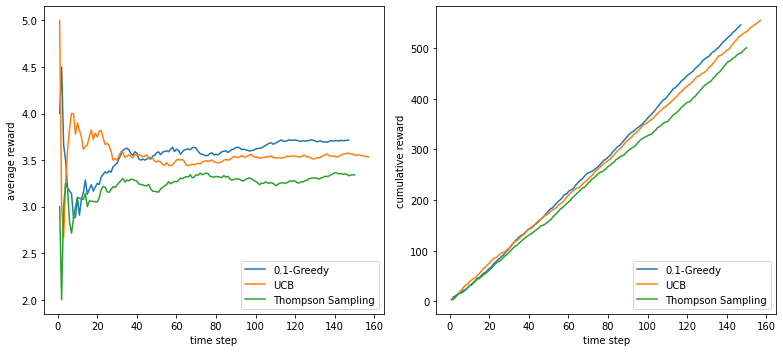

In [ ]:
# plot results
plot_rewards(*policies)
if SCORES_LOG is True:
    plot_action_values(*policies)

In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p recohut

Author: Sparsh A.

Last updated: 2021-12-26 05:47:55

recohut: 0.0.7

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.1.5
seaborn   : 0.11.2
torch     : 1.10.0+cu111
IPython   : 5.5.0
numpy     : 1.19.5
matplotlib: 3.2.2

